In [7]:
# wasserstein_demo.py
# Wasserstein distance from scratch

import numpy as np

def first_nonzero(vec):
  dim = len(vec)
  for i in range(dim):
    if vec[i] > 0.0:
      return i
  return -1  # no empty cells found

def move_dirt(dirt, di, holes, hi):
  # move as much dirt at [di] as possible to h[hi]
  if dirt[di] <= holes[hi]:   # use all dirt
    flow = dirt[di]
    dirt[di] = 0.0            # all dirt got moved
    holes[hi] -= flow         # less to fill now
  elif dirt[di] > holes[hi]:  # use just part of dirt
    flow = holes[hi]          # fill remainder of hole
    dirt[di] -= flow          # less dirt left
    holes[hi] = 0.0           # hole is filled
  dist = np.abs(di - hi)
  return flow * dist          # work

def my_wasserstein(p, q):
  dirt = np.copy(p) 
  holes = np.copy(q)
  tot_work = 0.0

  while True:  # TODO: add sanity counter check
    from_idx = first_nonzero(dirt)
    to_idx = first_nonzero(holes)
    if from_idx == -1 or to_idx == -1:
      break
    work = move_dirt(dirt, from_idx, holes, to_idx)
    tot_work += work
  return tot_work  

def kullback_leibler(p, q):
  n = len(p)
  sum = 0.0
  for i in range(n):
    sum += p[i] * np.log(p[i] / q[i])
  return sum

def symmetric_kullback(p, q):
  a = kullback_leibler(p, q)
  b = kullback_leibler(q, p)
  return a + b

def main():
  print("\nBegin Wasserstein distance demo ")

  P =  np.array([0.6, 0.1, 0.1, 0.1, 0.1])
  Q1 = np.array([0.1, 0.1, 0.6, 0.1, 0.1])
  Q2 = np.array([0.1, 0.1, 0.1, 0.1, 0.6])

  kl_p_q1 = symmetric_kullback(P, Q1)
  kl_p_q2 = symmetric_kullback(P, Q2)

  wass_p_q1 = my_wasserstein(P, Q1)
  wass_p_q2 = my_wasserstein(P, Q2)

  print("\nKullback-Leibler distances: ")
  print("P to Q1 : %0.4f " % kl_p_q1)
  print("P to Q2 : %0.4f " % kl_p_q2)  # should be greater

  print("\nWasserstein distances: ")
  print("P to Q1 : %0.4f " % wass_p_q1)
  print("P to Q2 : %0.4f " % wass_p_q2)  # should be greater

  print("\nEnd demo ")

if __name__ == "__main__":
  main()



Begin Wasserstein distance demo 

Kullback-Leibler distances: 
P to Q1 : 1.7918 
P to Q2 : 1.7918 

Wasserstein distances: 
P to Q1 : 1.0000 
P to Q2 : 2.0000 

End demo 


In [6]:
# Author: Remi Flamary <remi.flamary@polytechnique.edu>
#
# License: MIT License

# sphinx_gallery_thumbnail_number = 2

import numpy as np
import matplotlib.pyplot as pl

import ot
import torch


ModuleNotFoundError: No module named 'ot'

In [8]:
nt = 100
nt1 = 10  #

ns1 = 50
ns = 2 * ns1

rng = np.random.RandomState(2)

xt = rng.randn(nt, 2) * 0.2
xt[:nt1, 0] += 1
xt[nt1:, 1] += 1


xs1 = rng.randn(ns1, 2) * 0.2
xs1[:, 0] += 1
xs2 = rng.randn(ns1, 2) * 0.2
xs2[:, 1] += 1

xs = np.concatenate((xs1, xs2))

# Sample reweighting matrix H
H = np.zeros((ns, 2))
H[:ns1, 0] = 1 / ns1
H[ns1:, 1] = 1 / ns1
# each columns sums to 1 and has weights only for samples form the
# corresponding source distribution

M = ot.dist(xs, xt)



NameError: name 'ot' is not defined

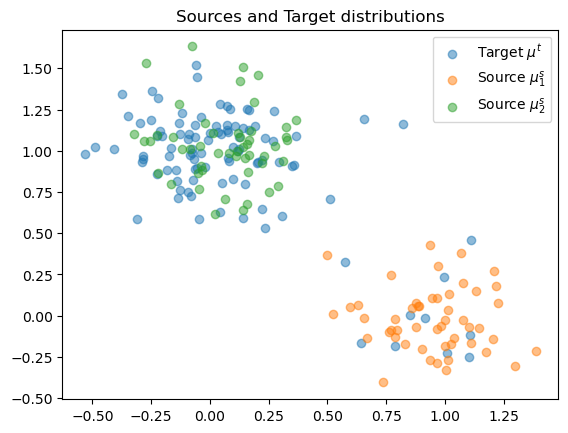

In [ ]:
pl.figure(1)
pl.scatter(xt[:, 0], xt[:, 1], label="Target $\mu^t$", alpha=0.5)
pl.scatter(xs1[:, 0], xs1[:, 1], label="Source $\mu^s_1$", alpha=0.5)
pl.scatter(xs2[:, 0], xs2[:, 1], label="Source $\mu^s_2$", alpha=0.5)
pl.title("Sources and Target distributions")
pl.legend()


In [ ]:
# convert numpy arrays to torch tensors
H2 = torch.tensor(H)
M2 = torch.tensor(M)

# weights for the source distributions
w = torch.tensor(ot.unif(2), requires_grad=True)

# uniform weights for target
b = torch.tensor(ot.unif(nt))

lr = 2e-3  # learning rate
niter = 500  # number of iterations
losses = []  # loss along the iterations

# loss for the minimal Wasserstein estimator


def get_loss(w):
    a = torch.mv(H2, w)  # distribution reweighting
    return ot.emd2(a, b, M2)  # squared Wasserstein 2


for i in range(niter):
    loss = get_loss(w)
    losses.append(float(loss))

    loss.backward()

    with torch.no_grad():
        w -= lr * w.grad  # gradient step
        w[:] = ot.utils.proj_simplex(w)  # projection on the simplex

    w.grad.zero_()


NameError: name 'torch' is not defined

In [ ]:
we = w.detach().numpy()
print("Estimated mixture:", we)

pl.figure(2)
pl.semilogy(losses)
pl.grid()
pl.title("Wasserstein distance")
pl.xlabel("Iterations")


NameError: name 'w' is not defined

In [ ]:
pl.figure(3)

# compute source weights
ws = H.dot(we)

pl.scatter(xt[:, 0], xt[:, 1], label="Target $\mu^t$", alpha=0.5)
pl.scatter(
    xs[:, 0],
    xs[:, 1],
    color="C3",
    s=ws * 20 * ns,
    label="Weighted sources $\sum_{k} w_k\mu^s_k$",
    alpha=0.5,
)
pl.title("Target and reweighted source distributions")
pl.legend()


https://pythonot.github.io/auto_examples/sliced-wasserstein/plot_variance_ssw.html